## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


## Цели исследования и описание шагов

Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека.
Для построения модели будем использовать библиотеку keras. Для получения baseline предсказаний построим модель архитектуры lenet, для улучшения используем модель resnet50, c замороженным верхним слоем.
Для обеих моделей используем одинаковое значение эпох обучения, learning rate.
Решается задача регрессии - предсказываем возраст покуателя, который является непрерывной величиной.

Будем использовать mean absolut errror и в качестве loss и в качестве метрики.

Для исследования будем использовать датасет с сайта appa-real-face-cropped.


1. Прежде всего необходимо провести сследовательский анализ набора фотографий чтобы выяснить:
- содержание данных
- их объем, формат, соответствие описанию
- распределение объектов, наличие пропусков и/или аномалий
2. Подготовка данных к обучению.
 В нашем случае подготовка будет заключаться в создании генератора данных библиотеки с помощью imagedatagenerator.
3. Обучение нейронной сети и оценка качества
Оценивать качество будем на валидационной выборке, без создания тестовой.

## Загрузка данных и библиотек

In [ ]:
# загрузка библиотек
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import ReLU
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPooling2D, Dense,Add, AveragePooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model,  Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
# создаем конфигурацию для использования gpu для обучения модели
tf.config.list_physical_devices('GPU')
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [ ]:
path = '/kaggle/input/appa-real-face-cropped/final_files'
#Распаковываем архив
#!unzip -q /content/drive/MyDrive/Projects_YP/age_recognition/final_files.zip \
#-d /content/drive/MyDrive/Projects_YP/age_recognition/final_files

print('Файлы распакованы')

In [ ]:
!ls  /kaggle/input/appa-real-face-cropped

файлы распакованы

In [ ]:
# создадим датафрейм
df = pd.read_csv('/kaggle/input/labels-csv/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет соответствует описанию, содержит 2 столбца:
- file_name содержит имя файла
- real_age целевой признак, в формате int

## Предварительный анализ и предобработка

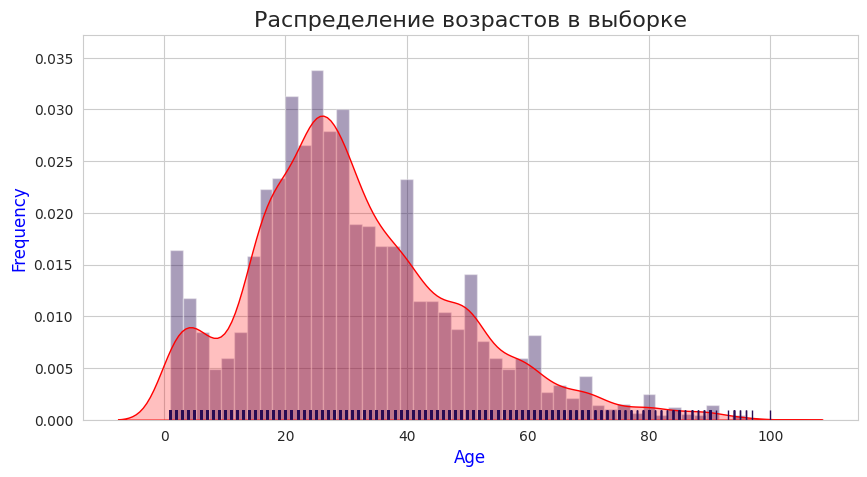

In [ ]:
# Посмотрим на объекты в нашей выборке
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(df['real_age'],
             rug=True,
             kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Распределение возрастов в выборке', fontsize=16)
plt.show()

Видим что выборка содержит все возрастные категории (до 100) но большинство объектов это объекты 20-40 лет

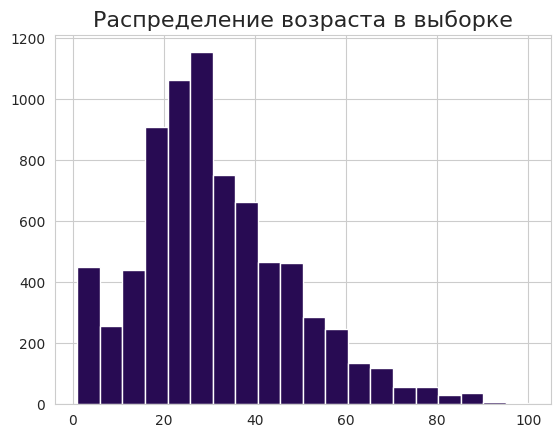

In [ ]:
df['real_age'].hist(bins = 20)
plt.title('Распределение возраста в выборке' , fontsize=16)
plt.show()

В выборке имеются редкие значения. Так например нужно детальнее изучить объекты до 10 лет, так как исходя из задания у нас не будет покупателей до 10 лет, которые могут совершать покупки и предлагать этой категории покупателей товары не имеет смысл.

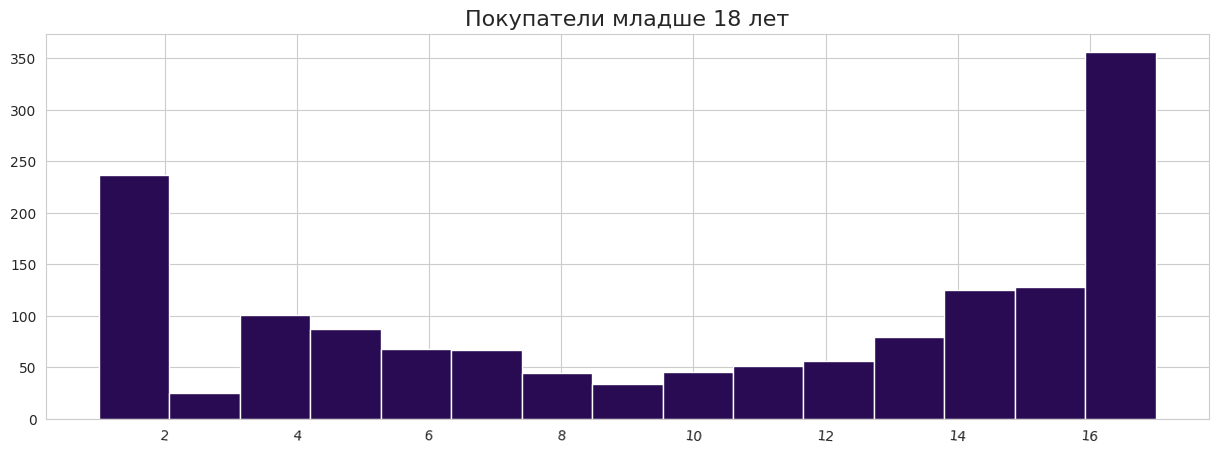

In [ ]:
# отобразим объекты менее 18 лет
df.loc[df['real_age'] < 18, 'real_age'].hist(bins = 15,
                                             figsize = (15,5))

plt.title('Покупатели младше 18 лет', fontsize = 16)
plt.xticks(rotation = -5)
plt.show()

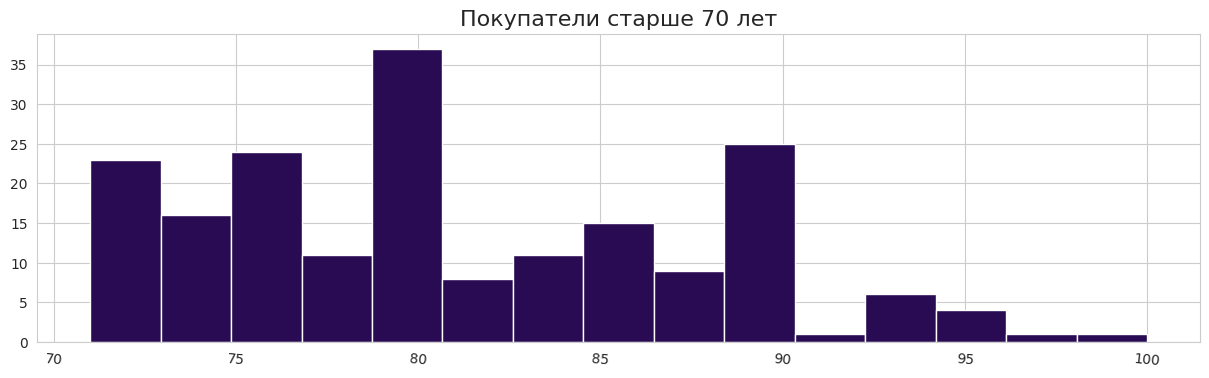

In [ ]:
# Оценим распределение признака для возрастной категории
df.loc[df['real_age'] > 70, 'real_age'].hist(bins = 15,
                                             figsize = (15,4))

plt.title('Покупатели старше 70 лет', fontsize = 16)
plt.xticks(rotation = -5)
plt.show()

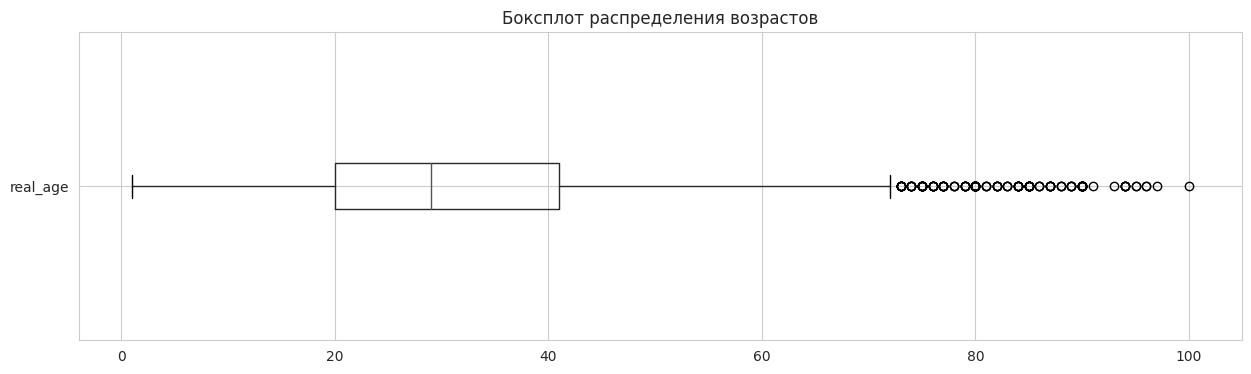

In [ ]:
# посмотрим на боксплот наших данных
df[['real_age']].boxplot(vert = False,
                        figsize = (15, 4))
plt.title('Боксплот распределения возрастов')
plt.show()

Боксплот подтверждает вывод о том, что для данного датасета объекты старше 70 лет относятся к редким значениям. В рамках обучения нейросетей это отразится в том, что такие редкие объекты нейросеть не сможет определять хорошо без дополнительной обработки, например увеличения количества редких значений. Но данная задача это задачп регрессии поэтому просто оставляем эти объекты

Вывод:

В результате предварительного анализа данных установили, что описание данных соответствует тому, что содержится в нашем датасете:

file_name содержит имя файла
real_age целевой признак, в формате int.
Данные содержат 7591 объектов Изображения имеют размер 256х256х3

Имеются изображения людей возрастом от 0 до 100 лет.

Объекты от 70 лет в наших данных являются редкими

## Создание модели

Подавать данные в модель будем используя загрузчик ImageDataGenerator



### Загрузчик

In [ ]:
# Инициируем загрузчик
datagen = ImageDataGenerator(rescale = 1./255, # маштабирование
                            validation_split = 0.2) # размер валидации

In [ ]:
with strategy.scope():
  # Загрузчик для обучающего датасета
    train = datagen.flow_from_dataframe(
    dataframe = df,
    directory = path,
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224, 224),
    shuffle = True,
    class_mode = 'raw', #чтобы целевой признак не обрабатвался
    batch_size = 32,
    seed = 12345,
    subset = 'training')

Found 6073 validated image filenames.


In [ ]:
with strategy.scope():# Загрузчик для валидационного датасета
     valid = datagen.flow_from_dataframe(
     dataframe = df,
     directory = path,
     x_col = 'file_name',
     target_size = (224, 224),
     y_col = 'real_age',
     class_mode = 'raw',
     shuffle=True,
     batch_size = 32,
     seed = 12345,
     subset = 'validation')

Found 1518 validated image filenames.


In [ ]:
# оценим размер изображений содержащихся в датасете
train.next()[0][0].shape

(224, 224, 3)

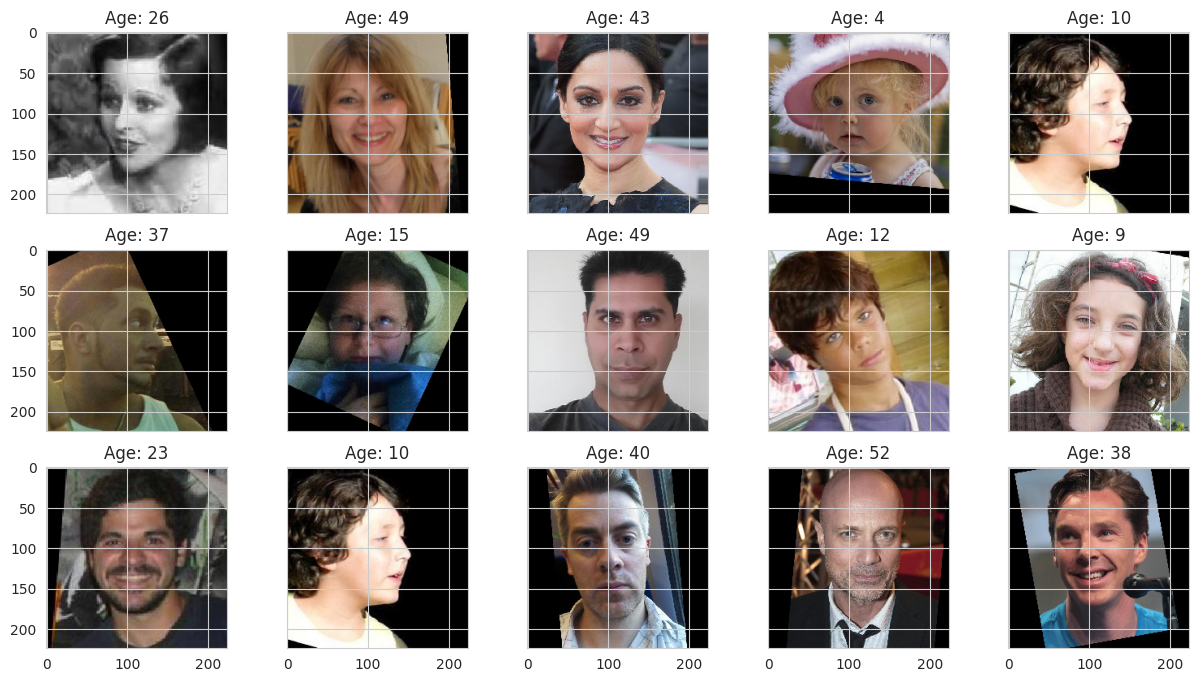

In [ ]:
# Посмотрим на содержащиеся картинки
fig, ax = plt.subplots(nrows = 3, ncols=5,figsize=(15, 8), \
                        sharey=True, sharex=True)
for ax_x in ax.flatten():
    # создадим генератор случайного номера батча
    random_batch = int(np.random.uniform(0, len(train)))

    # выберем случайный батч
    batch = train[random_batch]

    # Получим изображение и целевой признак
    image, label  = batch

    #данные изображения
    character = image[0]

    age = label[0]

    # выводим изображения
    ax_x.imshow(character)
    ax_x.set_title(f'Age: {age}')
plt.show()

Фотографии соответствуют описанию

## Baseline model

Для того, чтобы понимать предсказательный потенциал и оценить прогресс начнем с простой нейронной сети архитектуры Lenet

In [ ]:
with strategy.scope():

    lenet = Sequential([
       Input (shape = (224,224,3)),
       Conv2D (32, (3,3),  strides = (1), padding = 'same', activation='relu'),
       AveragePooling2D (pool_size = (2, 2)),
       Conv2D (64, (3,3),  strides = (1), padding = 'same', activation='relu'),
       AveragePooling2D (pool_size = (2, 2)),
       Conv2D (128, (3,3),  strides = (1), padding = 'same', activation='relu'),
       AveragePooling2D (pool_size = (2, 2)),
       Conv2D (256, (3,3),  strides = (1), padding = 'same', activation='relu'),
       AveragePooling2D (),
       Conv2D (512, (3,3),  strides = (1), padding = 'same', activation='relu'),
       Flatten(),
       Dense(1024, activation='relu'),
       Dense(1, activation='relu')
       ])

    lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_squared_error', metrics = ['mae'])
    lenet.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 average_pooling2d_58 (Aver  (None, 112, 112, 32)      0         
 agePooling2D)                                                   
                                                                 
 conv2d_96 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 average_pooling2d_59 (Aver  (None, 56, 56, 64)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_97 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 average_pooling2d_60 (Aver  (None, 28, 28, 128)     

In [ ]:
with strategy.scope():
    history_lenet = lenet.fit(train, epochs = 20, validation_data = valid, verbose = 1)

Epoch 1/20
190/190 [==============================] - 37s 171ms/step - loss: 342.0785 - mae: 14.1227 - val_loss: 269.6033 - val_mae: 12.7530
Epoch 2/20
190/190 [==============================] - 29s 152ms/step - loss: 279.6535 - mae: 12.8706 - val_loss: 275.2884 - val_mae: 13.5254
Epoch 3/20
190/190 [==============================] - 29s 151ms/step - loss: 265.8937 - mae: 12.5875 - val_loss: 302.5274 - val_mae: 14.4043
Epoch 4/20
190/190 [==============================] - 29s 151ms/step - loss: 255.5123 - mae: 12.3366 - val_loss: 234.9203 - val_mae: 12.2323
Epoch 5/20
190/190 [==============================] - 29s 153ms/step - loss: 243.0657 - mae: 12.0385 - val_loss: 221.2674 - val_mae: 11.8475
Epoch 6/20
190/190 [==============================] - 29s 152ms/step - loss: 232.1912 - mae: 11.7001 - val_loss: 220.7122 - val_mae: 11.8551
Epoch 7/20
190/190 [==============================] - 29s 151ms/step - loss: 221.2968 - mae: 11.4163 - val_loss: 208.7459 - val_mae: 11.4086
Epoch 8/20
19

In [ ]:
history_lenet.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

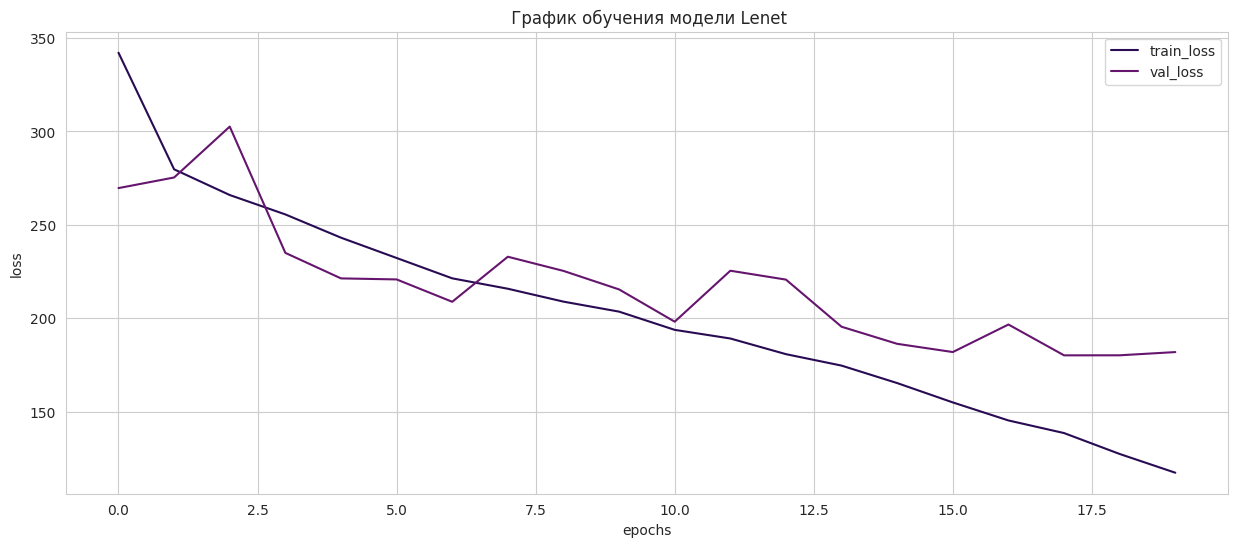

In [ ]:
# построим график обучения модели
plt.figure(figsize=(15, 6))
plt.plot(history_lenet.history['loss'], label = "train_loss")
plt.plot(history_lenet.history['val_loss'], label="val_loss")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title(' График обучения модели Lenet')
plt.show()

Видим что модель обучается равномерно, на валиационной выборке метрика мае достигла 10.55.

## ResNet50

Для предсказания будем использовать модель resnet50, у которой на последнем слое будет 1 нейрон и функция активации linear'.

In [ ]:
def create_model(input_shape):# we will use ResNet50 architecture, with freezing top layers
    backbone = ResNet50(input_shape = input_shape, weights = 'imagenet', include_top = False)
    model = Sequential()
    model.add(backbone)

    #now we will add our custom layers
    #without drop layer, neural networks can easily overfit
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    #final layer, since we are doing regression we will add only one neuron (unit)
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr  = 0.0003)
    model.compile(optimizer = optimizer, loss = 'mae', metrics=['mae'])
    print(model.summary())

    return model

In [ ]:
input_shape = (224,224,3)
with strategy.scope():
    resnet = create_model(input_shape)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_18 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_48 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None


In [ ]:
with strategy.scope():
    history_resnet = resnet.fit(train, epochs = 20, validation_data = valid, verbose = 2)

Epoch 1/20


2023-11-25 14:02:00.183154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_32/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


190/190 - 123s - loss: 15.4599 - mae: 15.4599 - val_loss: 18.2003 - val_mae: 18.2003 - 123s/epoch - 649ms/step
Epoch 2/20
190/190 - 55s - loss: 11.3799 - mae: 11.3799 - val_loss: 12.9478 - val_mae: 12.9478 - 55s/epoch - 289ms/step
Epoch 3/20
190/190 - 55s - loss: 10.5661 - mae: 10.5661 - val_loss: 13.0502 - val_mae: 13.0502 - 55s/epoch - 292ms/step
Epoch 4/20
190/190 - 55s - loss: 10.0939 - mae: 10.0939 - val_loss: 14.6548 - val_mae: 14.6548 - 55s/epoch - 289ms/step
Epoch 5/20
190/190 - 55s - loss: 9.4842 - mae: 9.4842 - val_loss: 11.5314 - val_mae: 11.5314 - 55s/epoch - 291ms/step
Epoch 6/20
190/190 - 55s - loss: 8.9150 - mae: 8.9150 - val_loss: 22.1851 - val_mae: 22.1851 - 55s/epoch - 290ms/step
Epoch 7/20
190/190 - 55s - loss: 8.4756 - mae: 8.4756 - val_loss: 10.0804 - val_mae: 10.0804 - 55s/epoch - 290ms/step
Epoch 8/20
190/190 - 55s - loss: 8.1197 - mae: 8.1197 - val_loss: 10.9563 - val_mae: 10.9563 - 55s/epoch - 289ms/step
Epoch 9/20
190/190 - 55s - loss: 7.5003 - mae: 7.5003 - v

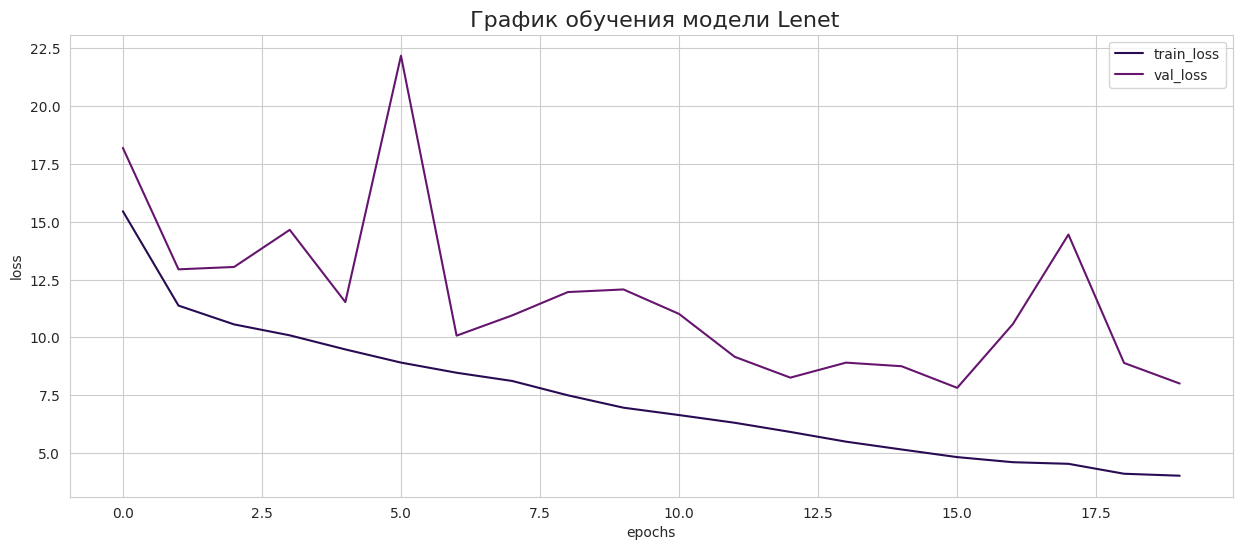

In [ ]:
# построим график обучения модели
plt.figure(figsize=(15, 6))
plt.plot(history_resnet.history['loss'], label = "train_loss")
plt.plot(history_resnet.history['val_loss'], label="val_loss")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title(' График обучения модели Lenet', fontsize = 16)
plt.show()

На графиках обучения моделей мы видим скачки на валидации, что может быть вызвано маленьким размером батча.

## Вывод

В результате проведенного исследования был загружен и проанализированы данные:

- общее количество  7591 изображений
- изображения имеют размер 256х256х3
- датафрейм с 2 колонками file_name (имя файла) и  real_age (целевой признак, в формате int)
- на изображения разные люди возрастом от 0 до 100 лет
- объекты от 70 лет в наших данных являются редкими

В работе мы проанализировали 2 модели:
 - CNN
 - resnet50

 | модель|CNN | ResNet50|
 |------|-------------|------|
 |  Mean Absolute Error| 10.5548 | 8.0098|

 Таким образом предобученная модель ResNet50 показала лучший результат.
